cnn에서 resnet도입해보기

layernormalization  해보기


+ 딥러닝 앙상블은 어떻게?

In [1]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [7]:
ls

'Colab Notebooks'/    submission.csv              'test_(6, 55)_0.001_20.pth'
 data_loader_v2/     'test_(6, 18)_0.001_20.pth'  'test_(7, 1)_0.001_20.pth'
 data.zip            'test_(6, 33)_0.001_20.pth'   test.csv
'My image model.tm'  'test_(6, 39)_0.001_20.pth'   train.csv


In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: submission.csv          
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
import torchvision.datasets as data
import torchvision.transforms as transforms
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch.nn as nn
from tqdm.auto import tqdm
import time
import gc

In [5]:
gc.collect()


0

In [6]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
submit=pd.read_csv("submission.csv")

데이터확인

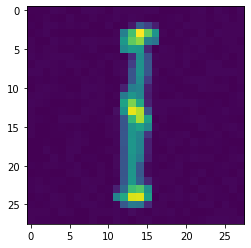

In [6]:

img=train.loc[0,'0':].values.reshape(28,28).astype(int)

plt.imshow(img)
plt.show()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [9]:
# 학습 파라미터 설정
learning_rate = 0.001
epochs = 20
batch_size = 5
Scaler = StandardScaler()

In [10]:
train

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,1,2,1,3,3,4,4,3,4,1,0,4,4,4,1,1,1,2,3,4,1,2,3,3,2,3,1,3,4,0,...,2,4,1,1,1,1,2,3,1,2,0,2,4,1,0,3,4,4,0,1,3,3,3,3,2,0,3,3,3,2,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,1,4,2,0,3,3,2,2,1,2,3,2,2,4,1,0,4,1,0,2,0,3,0,2,3,3,3,4,0,4,...,0,1,1,1,1,3,0,4,2,0,4,3,1,4,0,1,0,0,3,3,0,0,1,3,3,1,2,0,3,2,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,4,3,4,0,1,3,4,1,0,2,2,0,0,3,3,2,0,4,3,2,3,4,3,1,1,4,4,4,1,1,...,3,2,4,3,2,1,1,0,4,0,4,4,1,3,3,1,3,4,1,0,2,4,1,2,4,4,4,3,4,2,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,3,0,1,4,0,0,0,2,3,1,1,1,0,2,4,1,0,3,0,1,2,4,1,4,3,1,4,4,4,0,...,0,0,2,0,2,3,2,0,3,0,1,0,1,0,1,2,3,2,1,1,0,0,3,1,4,1,1,2,1,3,2,3,1,1,0,4,1,4,3,1


In [11]:
x_train=train.loc[:,'0':]
y_train=train['digit']

x_test=test.loc[:,'0':]

In [12]:
x_train=np.array(x_train)
y_train=np.array(y_train)

x_test=np.array(x_test)


In [13]:
x_train = x_train.reshape(-1,1, 28, 28)

x_test=x_test.reshape(-1,1,28,28)

In [14]:
x_train.shape

(2048, 1, 28, 28)

##validation

In [15]:
x_train=torch.FloatTensor(x_train)
y_train=torch.LongTensor(y_train)

x_test=torch.FloatTensor(x_test)

In [16]:
x_train, x_val, y_train, y_val= train_test_split(x_train,y_train,test_size=0.3,random_state=1)

In [17]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)

val_dataset=torch.utils.data.TensorDataset(x_val,y_val)

In [18]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

val_loader=torch.utils.data.DataLoader(dataset=val_dataset,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       drop_last=True
                                       )


In [16]:
y_train.type

<function Tensor.type>

# CNN 모델

In [19]:

class baseline_CNN(torch.nn.Module):
  def __init__(self):
    super(baseline_CNN,self).__init__() 

    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1,128,kernel_size=3,stride=1,padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.3),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    )
#layernormalization 

    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.3),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    ) 

    self.fc = torch.nn.Linear(7*7*256,10,bias=True)
    torch.nn.init.kaiming_uniform(self.fc.weight)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1)     
    out = self.fc(out)
    return out

In [20]:
model = baseline_CNN().to(device)

In [21]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler =torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=250)

In [22]:
# train loss와 val loss 지정.
total_loss = 0.0
total_val_loss = 0.0

# 모델 이름을 위해서 변수 만듦.
version = time.localtime()[3:5]
curr_lr = learning_rate

n_val_loss = 10000000. # 가장 낮은 validation loss를 저장하기 위해서 변수 설정.

In [23]:
total_step = len(train_loader) * epochs
print(f"Total step is....{total_step}") # 모델이 학습하는 전체 step 계산.

Total step is....5720


In [24]:
for epoch in range(epochs):
    total_loss=0
    total_val_loss=0

    for i,(X_train, Y_train) in enumerate(tqdm(train_loader, desc='*********Train mode*******')):
        if torch.cuda.is_available():
          
            X_train = X_train.float().to(device)
            Y_train = Y_train.long().to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()
        # Forward 계산
        hypothesis = model(X_train)
        # Error 계산
        loss = loss_fn(hypothesis, Y_train)
        # Backparopagation
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        #lr 스케줄러 갱신
        scheduler.step()

        total_loss += loss.item()
        # 평균 Error 계산
        torch.cuda.empty_cache()
        
    train_loss = total_loss / len(train_loader)
    
    print ("Epoch [{}/{}], Train Loss: {:.4f}".format(epoch+1, epochs, train_loss))



    model.eval()

    with torch.no_grad():
      for i,(X_val, Y_val) in enumerate(tqdm(val_loader, desc='*********Evaluation mode*******')):
        X_val=X_val.float().to(device)
        Y_val=Y_val.long().to(device)

        hypothesis = model(X_val)
        loss_val = loss_fn(hypothesis,Y_val)

        total_val_loss += loss_val.item()


    val_loss = total_val_loss / len(val_loader)
    print ("Epoch [{}/{}], Eval Loss: {:.4f}".format(epoch+1, epochs, val_loss))


    if val_loss < n_val_loss:
      n_val_loss = val_loss
      torch.save(model.state_dict(), f'test_{version}_{learning_rate}_{epochs}.pth')
      print("Best Model saved......")



Epoch [1/20], Train Loss: 4.7839



Epoch [1/20], Eval Loss: 3.0793
Best Model saved......



Epoch [2/20], Train Loss: 1.4980



Epoch [2/20], Eval Loss: 1.4127
Best Model saved......



Epoch [3/20], Train Loss: 1.1072



Epoch [3/20], Eval Loss: 1.3018
Best Model saved......



Epoch [4/20], Train Loss: 0.8997



Epoch [4/20], Eval Loss: 1.0401
Best Model saved......



Epoch [5/20], Train Loss: 0.7310



Epoch [5/20], Eval Loss: 0.9233
Best Model saved......



Epoch [6/20], Train Loss: 0.6429



Epoch [6/20], Eval Loss: 0.8796
Best Model saved......



Epoch [7/20], Train Loss: 0.5366



Epoch [7/20], Eval Loss: 0.8845



Epoch [8/20], Train Loss: 0.4765



Epoch [8/20], Eval Loss: 1.0413



Epoch [9/20], Train Loss: 0.3611



Epoch [9/20], Eval Loss: 0.9555



Epoch [10/20], Train Loss: 0.2540



Epoch [10/20], Eval Loss: 1.0304



Epoch [11/20], Train Loss: 0.2132



Epoch [11/20], Eval Loss: 0.9570



Epoch [12/20], Train Loss: 0.1399



Epoch [12/20], Eval Loss: 1.0533



Epoch [13/20], Train Loss: 0.1136



Epoch [13/20], Eval Loss: 1.0268



Epoch [14/20], Train Loss: 0.1032



Epoch [14/20], Eval Loss: 1.0104



Epoch [15/20], Train Loss: 0.0563



Epoch [15/20], Eval Loss: 1.2540



Epoch [16/20], Train Loss: 0.0590



Epoch [16/20], Eval Loss: 1.4581



Epoch [17/20], Train Loss: 0.1204



Epoch [17/20], Eval Loss: 1.2083



Epoch [18/20], Train Loss: 0.1159



Epoch [18/20], Eval Loss: 1.2000



Epoch [19/20], Train Loss: 0.0723



Epoch [19/20], Eval Loss: 1.0732



Epoch [20/20], Train Loss: 0.0246



Epoch [20/20], Eval Loss: 1.2577


##Test

In [25]:
x_test=x_test.to(device)

In [26]:
test_model = baseline_CNN()

weights = torch.load(f'test_{version}_{learning_rate}_{epochs}.pth', map_location='cuda:0')
#모델


In [27]:
test_model.load_state_dict(weights)
test_model = test_model.to(device)
test_model.eval()

baseline_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)

In [28]:
with torch.no_grad():
   outputs = test_model(x_test)
pred_test = outputs

RuntimeError: ignored